# 科学技術計算 6 レポート


In [ ]:
import numpy as np
import scipy 
from scipy.optimize import OptimizeResult

from numpy.linalg import inv, norm, solve, det, matrix_rank, cond
from numpy import diag
rng = np.random.default_rng()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"
from matplotlib.colors import BoundaryNorm

from typing import List, Optional, Union, Tuple, Dict

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from scipy.optimize import line_search





## 課題06-1

In [ ]:
#描画関数
def visualize_f(
        f: callable,
        ax: matplotlib.axis.Axis,
        x_min: float = -10,
        x_max: float = +10,
        y_min: float = -10,
        y_max: float = +10,
        levels: int = 20,
        cmap: plt.cm = plt.cm.gray_r,
        norm = None,
        ) -> matplotlib.axis.Axis:
    """目的関数 f の可視化

    Args:
        f (callable, 'f(x: np.ndarray)'): 目的関数 f(x)
        ax (matplotlib.figure.Axis): matplotlibのaxisオブジェクト
        x_min (float, optional): xの最小値．デフォルトは-10
        x_max (float, optional): xの最大値．デフォルトは+10
        y_min (float, optional): yの最小値．デフォルトは-10
        y_max (float, optional): yの最大値．デフォルトは+10
        levels (int, optional): 等高線の本数．デフォルトは20
    """

    # プロット範囲を設定
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # 格子状の点を作成
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]

    # 格子状の各点でf()を評価
    Z = np.array([f(x) for x in np.c_[XX.ravel(), YY.ravel()]])

    # 1次元配列を2次元に変換
    Z = Z.reshape(XX.shape)

    # 濃淡表示
    ax.pcolormesh(XX, YY, Z, norm=norm, cmap=cmap, zorder=-10)

    # 等高線を表示
    cs = ax.contour(
        XX,
        YY,
        Z,
        colors="k",
        linestyles="-",
        linewidths=1,
        levels=levels
    )
    ax.clabel(cs, colors="k", fontsize="xx-small")
    ax.set_aspect("equal")

    return ax

In [ ]:
#継承関数
class FunctionJax():
    """
    JAXを用いた基底クラス．目的関数を派生クラスで定義する．
    """

    def __init__(self):
        self.g = jax.grad(self.forward)
        self.H = jax.hessian(self.forward)

    def forward(self, x: jnp.ndarray) -> float:
        """
        目的関数f(x)を定義するためのインターフェース．
        派生クラスでこのメソッドを実装する必要がある．
        """
        raise NotImplementedError

    def __call__(self, x: jnp.ndarray) -> float:
        """f(x)の値を計算"""
        return self.forward(x)

    def grad(self, x: jnp.ndarray) -> jnp.ndarray:
        """f(x)の勾配を計算"""
        return self.g(x)

    def hessian(self, x: jnp.ndarray) -> jnp.ndarray:
        """f(x)のヘッセ行列を計算"""
        return self.H(x)


#目的関数を作成
class AnotherNonConvexFunctionJax(FunctionJax):
    def forward(self, x: jnp.ndarray) -> float:
        x0, x1 = x[0], x[1]
        return (
            0.05 * (x0**4 + x1**4)
            - (x0**2 + x1**2)
            + 0.5 * (x0 + x1)
        )



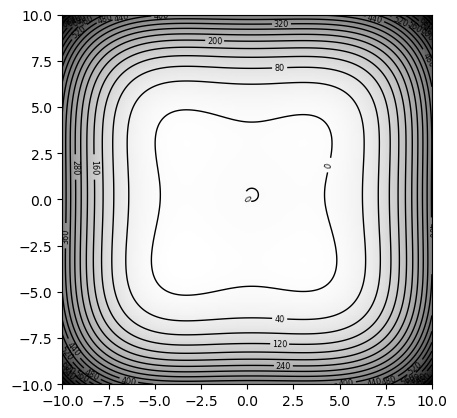

[-1.3 -1.9]
[[-1.4        0.       ]
 [ 0.         0.4000001]]


In [ ]:
    
f = AnotherNonConvexFunctionJax()
fig, ax = plt.subplots()
visualize_f(f, ax)
plt.show()

f.grad(jnp.array([1.0, 2.0]))
f.hessian(jnp.array([1.0, 2.0]))
x = jnp.array([1.0, 2.0])
print(f.grad(x))
print(f.hessian(x))


## 課題6-2

In [ ]:
class NonConvexFunction():
    """
    独自の非凸関数
    https://www.wolframalpha.com/input?i=Plot%5B%7B2+%28x%2B1%29%5E2+%2B+2+%28y%2B1%29%5E2+%2B+2%28x%2B1%29+%28y%2B1%29+-+2.5%28x%2B1%29+-+2.5+%28y%2B1%29++%2B+250+exp%28-%28%28x-2%29%5E2+%2B+%28y-2%29%5E2%29%2F30%29+%7D%2C+%7Bx%2C+-10%2C+10%7D%2C+%7By%2C+-10%2C+10%7D%5D&lang=ja
    """

    def __call__(self, x: np.ndarray) -> float:
        """関数f(x)"""
        assert x.ndim == 1 and len(x) == 2
        val = 2 * (x[0] + 1)**2 \
            + 2 * (x[1] + 1)**2 \
            + 2 * (x[0] + 1) * (x[1] + 1) \
            - 2.5 * (x[0] + 1) \
            - 2.5 * (x[1] + 1) \
            + 250 * np.exp(-((x[0] - 2)**2 + (x[1] - 2)**2) / 30) \
            + 100
        return val / 60

    def grad(self, x: np.ndarray) -> np.ndarray:
        """f(x)の勾配"""
        assert x.ndim == 1 and len(x) == 2
        val0 = -50 / 3 * (x[0] - 2) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4 * x[0] + 2 * x[1] + 3.5
        val1 = -50 / 3 * (x[1] - 2) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4 * x[1] + 2 * x[0] + 3.5
        return np.array([val0, val1]) / 60

    def hessian(self, x: np.ndarray) -> np.ndarray:
        """f(x)のヘッセ行列"""
        assert x.ndim == 1 and len(x) == 2
        val00 = 10 / 9 * (x[0]**2 - 4 * x[0] - 11) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4
        val01 = 10 / 9 * (x[0] - 2) * (x[1] - 2) * np.exp(1 / 30 * (-(x[0] - 4) * x[0] - (x[1] - 4) * x[1] - 8)) + 2
        val10 = 10 / 9 * (x[0] - 2) * (x[1] - 2) * np.exp(1 / 30 * (-(x[0] - 4) * x[0] - (x[1] - 4) * x[1] - 8)) + 2
        val11 = 10 / 9 * (x[1]**2 - 4 * x[1] - 11) * np.exp(1 / 30 * (-(x[0] - 2)**2 - (x[1] - 2)**2)) + 4
        return np.array([[val00, val01], [val10, val11]]) / 60


In [ ]:
def update_matrix(M, s, y, update, method):
    if method == "BFGS":
        if update == "H":
            ys = y @ s
            if ys <= 1e-10:
                return M
            I = np.eye(len(s))
            return (
                (I - np.outer(s, y) / ys)
                @ M
                @ (I - np.outer(y, s) / ys)
                + np.outer(s, s) / ys
            )
        else:  # B
            Bs = M @ s
            ys = y @ s
            if ys <= 1e-10:
                return M
            return (
                M
                - np.outer(Bs, Bs) / (s @ Bs)
                + np.outer(y, y) / ys
            )

    elif method == "DFP":
        # BFGSの双対
        return update_matrix(M, y, s, update, "BFGS")

    elif method == "SR1":
        if update == "H":
            v = s - M @ y
            denom = v @ y
        else:
            v = y - M @ s
            denom = v @ s

        if abs(denom) < 1e-10:
            return M
        return M + np.outer(v, v) / denom


In [ ]:
def quasi_newton(
        f: callable,
        g: callable,
        x0: np.ndarray,
        update: str,   # "B" or "H"
        method: str,   # "BFGS", "DFP", "SR1"
        maxiter: int = 100,
        callback: callable = None,
) -> np.ndarray:

    x = x0.copy()
    n = len(x)
    M = np.eye(n)   # B or H

    gk = g(x)

    for k in range(maxiter):

        # 探索方向
        if update == "H":
            dk = -M @ gk
        else:
            dk = -np.linalg.solve(M, gk)

        # 直線探索
        alpha, *_ = scipy.optimize.line_search(f, g, x, dk)
        if alpha is None:
            alpha = 1e-3

        x_new = x + alpha * dk
        g_new = g(x_new)

        s = x_new - x
        y = g_new - gk

        # 更新
        M = update_matrix(M, s, y, update, method)

        if callback:
            callback(x_new)

        # 終了判定
        if np.linalg.norm(s) < 1e-8 or np.linalg.norm(g_new) < 1e-8:
            return x_new

        x, gk = x_new, g_new

    return x


In [ ]:
class CacheXk():
    """多次元の解xkの履歴を記録するクラス"""


    def __init__(
            self,
            f: callable,
            g: callable,
            x0: np.ndarray,
            name: str
        ):
        """コンストラクタ

        Args:
            f (callable, ``f(x: np.ndarray)``): 目的関数 f
            g (callable, ``g(x: np.ndarray)``): 導関数 f'
            x0 (np.ndarray): 初期値
            name (str): キャッシュ名
        """
        assert hasattr(x0, "copy")
        self.__x_series = [x0.copy()]
        self.__f_series = [f(x0)]
        self.__g_series = [norm(g(x0))]
        self.f = f
        self.g = g
        self.__name = str(name)

    def __call__(self, xk: np.ndarray) -> None:
        """xkをキャッシュに追加するコールバック

        Args:
            xk (np.ndarray): 現在の解 x_k
        """
        assert hasattr(xk, "copy")
        self.__x_series.append(xk.copy())
        self.__f_series.append(self.f(xk))
        self.__g_series.append(norm(self.g(xk)))

    def get_x(self) -> np.ndarray:
        """x0, x1, ..., xkの履歴を取得"""
        return np.array(self.__x_series)

    def get_f(self) -> np.ndarray:
        """f(x0), f(x1), ..., f(xk)の履歴を取得"""
        return np.array(self.__f_series)

    def get_g(self) -> np.ndarray:
        """||f'(x0)||, ||f'(x1)||, ..., ||f'(xk)||の履歴を取得"""
        return np.array(self.__g_series)

    def get_name(self) -> str:
        """キャッシュ名を取得"""
        return str(self.__name)

    def set_name(self, name:str) -> None:
        """キャッシュ名を設定"""
        self.__name = str(name)

In [ ]:
class PlotCacheXk():
    """CacheXkオブジェクトをプロットするクラス"""


    def __init__(self, caches: List[CacheXk]) -> None:
        assert isinstance(caches, List), "should be a list of CacheXk"
        self.caches = caches
        self.f = caches[0].f
        self.x_label = "iterations k"
        self.colors = ['r', 'g', 'b', 'c', 'm', 'y']

    def plot_2d(self, figsize:tuple = (5, 5)) -> Dict[str, plt.figure]:
        """解の収束と目的関数の変化をプロットする

        Args:
            figsize (tuple, optional): 図のサイズ．デフォルトは(5, 5)

        Returns:
            Dict[str, plt.figure]: 各プロットのfigオブジェクト
        """
        return {
            "convergence": self.plot_convergence(),
            "x_over_f": self.plot_x_over_f(figsize)
        }


    def plot_convergence(self) -> plt.figure:
        """反復回数に対するx, f, および ||f'|| の3つのプロットを作成

        Returns:
            plt.figure: プロットのfigオブジェクト
        """

        fig = plt.figure()
        axs = fig.subplots(3, sharex=True)

        ax = axs[0]
        for cache, color in zip(self.caches, self.colors):
            ax.plot(cache.get_x()[:, 0], '.-', color=color,
                    label="x of " + cache.get_name())
            ax.plot(cache.get_x()[:, 1], '.--', color=color,
                    label="y of " + cache.get_name())
        ax.set_ylabel("$x_k$")
        ax.legend()

        ax = axs[1]
        for cache, color in zip(self.caches, self.colors):
            ax.plot(cache.get_f(), '.-', color=color, label=cache.get_name())
        ax.set_ylabel("$f(x_k)$")
        ax.legend()

        ax = axs[2]
        for cache, color in zip(self.caches, self.colors):
            ax.plot(cache.get_g(), '.-', color=color, label=cache.get_name())
        ax.set_ylabel("$\\| g(x_k) \\|$")
        ax.set_xlabel(self.x_label)
        ax.legend()

        plt.show()
        return fig

    def plot_x_over_f(self, figsize: tuple) -> plt.figure:
        """等高線付きのf(x)と(x, f(x))の系列を描画

        Args:
            figsize (tuple): 図のサイズ

        Returns:
            plt.figure: プロットのfigオブジェクト
        """
        fig = plt.figure(figsize=figsize)
        ax = fig.subplots()

        for cache, color in zip(self.caches, self.colors):
            x_series = cache.get_x()
            ax.scatter(
                x_series[0, 0],
                x_series[0, 1],
                color="w",
                s=50,
                edgecolors=color)
            ax.scatter(
                x_series[-1, 0],
                x_series[-1, 1],
                color=color,
                s=5,
                label=cache.get_name())
            ax.plot(
                x_series[:, 0],
                x_series[:, 1],
                marker='.',
                markersize=3,
                lw=1,
                color=color)

        ax = visualize_f(self.f, ax)

        ax.legend()
        plt.show()

        return fig


In [ ]:
methods = ["BFGS", "DFP", "SR1"]
updates = ["B", "H"]

x0_list = [
    np.array([-7.0, 7.0]),
    np.array([-4.0, 2.0]),
    np.array([0.0, 7.5]),
]

for f in [
    AnotherNonConvexFunctionJax(),
    NonConvexFunction(),
]:
    callback_list = []

    for x0 in x0_list:
        for update in updates:
            for method in methods:

                label = f"{update}-{method} from {x0}"
                cache = CacheXk(f, f.grad, x0, label)

                x = quasi_newton(
                    f,
                    f.grad,
                    x0,
                    update=update,
                    method=method,
                    maxiter=50,
                    callback=cache,
                )

                print(label, "→", x)
                callback_list.append(cache)

    PlotCacheXk(callback_list).plot_2d()
